In [ ]:
import math
import numpy as np

# Reading/Writing Data
import pandas as pd
import os
import csv

# For Progress Bar
from tqdm import tqdm

# Pytorch
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import scipy

# %%
def same_seed(seed): 
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def train_valid_split(data_set, valid_ratio, seed):
    '''Split provided training data into training set and validation set'''
    valid_set_size = int(valid_ratio * len(data_set)) 
    train_set_size = len(data_set) - valid_set_size
    train_set, valid_set = random_split(data_set, [train_set_size, valid_set_size], generator=torch.Generator().manual_seed(seed))
    return np.array(train_set), np.array(valid_set)

def predict(test_loader, model, device):
    model.eval() # Set your model to evaluation mode.
    preds = []
    for x in tqdm(test_loader):
        x = x.to(device)                        
        with torch.no_grad():                   
            pred = model(x)                     
            preds.append(pred.detach().cpu())   
    preds = torch.cat(preds, dim=0).numpy()  
    return preds

# %% [markdown]
# # Dataset

# %%
class myDataset(Dataset):
    '''
    x: Features.
    y: Targets, if none, do prediction.
    '''
    def __init__(self, x, y=None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)

    def __getitem__(self, idx):
        sample = self.x[idx]
        if len(sample.shape) == 2:  
            sample = sample.unsqueeze(0)  # Add channel dimension for CNN input
        if self.y is None:
            return sample
        else:
            return sample, self.y[idx]

    def __len__(self):
        return len(self.x)

# %% [markdown]
# # Neural Network Model
# Try out different model architectures by modifying the class below.

# %%
class image2sequence(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(image2sequence, self).__init__()
        #input : 1*16*16
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, 5, 1, 2), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2), #88
            
            nn.Conv2d(32, 64, 5, 1, 2),
            nn.BatchNorm2d(64), 
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2), #44

            
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64), 
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2) #22
        )

        self.fc = nn.Sequential(
            nn.Linear(64*2*2, 256),
            # nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(256, 256),
            # nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = x.squeeze(1) # (B, 1) -> (B)
        return x

class sequence2sequence(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, dropout=0.5):
        super(sequence2sequence, self).__init__()
        # TODO: modify model's structure, be aware of dimensions. 
        neuron_num = [input_dim] + hidden_dim + [output_dim]
        layers = []
        for i in range(1, len(neuron_num)):
            layers.append(nn.Linear(neuron_num[i-1], neuron_num[i]))
            if i < len(neuron_num) - 1:
                layers.append(nn.BatchNorm1d(neuron_num[i]))
                layers.append(nn.ReLU())
                layers.append(nn.Dropout(dropout))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = self.layers(x)
        x = x.squeeze(1) # (B, 1) -> (B)
        return x

class MLPS(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, dropout=0.5):
        super(MLPS, self).__init__()
        # TODO: modify model's structure, be aware of dimensions. 
        self.num_phi_slices = output_dim[1]
        self.theta_dim = output_dim[0]

        self.mlps = nn.ModuleList()
        neuron_num = [input_dim] + hidden_dim + [self.theta_dim]

        for _ in range(self.num_phi_slices):
            layers = []
            for j in range(1, len(neuron_num)):
                layers.append(nn.Linear(neuron_num[j-1], neuron_num[j]))
                if j < len(neuron_num) - 1:
                    layers.append(nn.BatchNorm1d(neuron_num[j]))
                    layers.append(nn.ReLU())
                    layers.append(nn.Dropout(dropout))
            self.layers = nn.Sequential(*layers)
            self.mlps.append(self.layers)
        

    def forward(self, x):
        output = list()
        for i in range(self.num_phi_slices):
            output.append(self.mlps[i](x))
        x = torch.stack(output, dim=2)  
        return x

class Generator(nn.Module):
    def __init__(self, input_dim=100, ngf=64, output_dim=3):
        """
        DCGAN 生成器
        
        参数:
        - nz (int): 潜入向量z的维度
        - ngf (int): 生成器特征图的基础深度
        - nc (int): 输出图像的通道数
        """
        super(Generator, self).__init__()
        self.ngf = ngf  # 基础特征图深度
        output_dim = output_dim[0] # [C,H,W]
        # -----------------------------------------------------
        # 步骤 1: Project and Reshape
        # 目标: 将 (B, nz) 的噪声向量转换为 (B, ngf * 8, 4, 4) 的初始特征图
        # B = batch_size
        # -----------------------------------------------------
        self.project_and_reshape = nn.Sequential(
            # "Project": 全连接层将 nz 维向量投射到高维空间
            # 4*4 是初始特征图的空间尺寸，ngf*8 是通道数
            nn.Linear(input_dim, ngf * 8 * 4 * 4), 
            
            # 批量归一化，稳定学习
            nn.BatchNorm1d(ngf * 8 * 4 * 4),
            
            # 使用 LeakyReLU 激活函数，引入非线性
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # -----------------------------------------------------
        # 步骤 2: 主体部分，使用转置卷积 (Transposed Convolution) 逐步放大
        # -----------------------------------------------------
        self.main = nn.Sequential(
            # 输入: (B, ngf * 8, 4, 4)
            # 输出: (B, ngf * 4, 8, 8)
            nn.ConvTranspose2d(in_channels=ngf * 8, out_channels=ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 输入: (B, ngf * 4, 8, 8)
            # 输出: (B, ngf * 2, 16, 16)
            nn.ConvTranspose2d(in_channels=ngf * 4, out_channels=ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 输入: (B, ngf * 2, 16, 16)
            # 输出: (B, ngf, 32, 32)
            nn.ConvTranspose2d(in_channels=ngf * 2, out_channels=ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 输入: (B, ngf, 32, 32)
            # 输出: (B, nc, 64, 64)
            nn.ConvTranspose2d(in_channels=ngf, out_channels=output_dim, kernel_size=4, stride=2, padding=1, bias=False),
            
            # 输出层使用 Tanh 激活函数，将输出归一化到 [-1, 1] 范围
            nn.Tanh()
        )

    def forward(self, input):
        """
        前向传播
        
        参数:
        - input (Tensor): 输入的噪声向量，形状为 (B, nz)
        """
        # 1. Project
        # 输入: (B, nz) -> 输出: (B, ngf * 8 * 4 * 4)
        x = self.project_and_reshape(input)
        
        ngf = self.ngf
        # 2. Reshape
        # 将一维向量重塑为三维张量，以匹配卷积层的输入要求
        # (B, ngf * 8 * 4 * 4) -> (B, ngf * 8, 4, 4)
        x = x.view(-1, ngf * 8, 4, 4) # -1 表示自动计算 batch_size
        
        # 3. 通过转置卷积层生成图像
        # (B, ngf * 8, 4, 4) -> (B, nc, 64, 64)
        output = self.main(x)
        
        return output

# %%
def select_feat(train_data, valid_data, test_data, input_dim, output_dim, select_all=True):
    '''Selects useful features to perform regression'''
    YTrain, YValidation, y_test = train_data[:,input_dim:], valid_data[:,input_dim:], test_data[:,input_dim:]
    raw_x_train, raw_XValidation, raw_x_test = train_data[:,:input_dim], valid_data[:,:input_dim], test_data[:,:input_dim]

    if select_all:
        feat_idx = list(range(raw_x_train.shape[1]))
    else:
        feat_idx = [0,1,2,3,4] # TODO: Select suitable feature columns.
        
    return raw_x_train[:,feat_idx], raw_XValidation[:,feat_idx], raw_x_test[:,feat_idx], YTrain, YValidation, y_test

# %% [markdown]
# # Training Loop

# %%
def trainer(train_loader, valid_loader, model, config, device):

    criterion = nn.MSELoss(reduction='mean') # Define your loss function, do not modify this.

    # Define your optimization algorithm. 
    # TODO: Please check https://pytorch.org/docs/stable/optim.html to get more available algorithms.
    # TODO: L2 regularization (optimizer(weight decay...) or implement by your self).
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate']) 
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=100) # Learning rate scheduler.
    writer = SummaryWriter() # Writer of tensoboard.

    if not os.path.isdir('./models'):
        os.mkdir('./models') # Create directory of saving models.

    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0

    for epoch in range(n_epochs):
        model.train() # Set your model to train mode.
        loss_record = []

        # tqdm is a package to visualize your training progress.
        # train_pbar = tqdm(train_loader, position=0, leave=True)

        for x, y in train_loader:
            optimizer.zero_grad()               # Set gradient to zero.
            x, y = x.to(device), y.to(device)   # Move your data to device. 
            pred = model(x)             
            loss = criterion(pred, y)
            loss.backward()                     # Compute gradient(backpropagation).
            optimizer.step()                    # Update parameters.
            step += 1
            loss_record.append(loss.detach().item())
            
            # Display current epoch number and loss on tqdm progress bar.
            # train_pbar.set_description(f'Epoch [{epoch+1}/{n_epochs}]')
            # train_pbar.set_postfix({'loss': loss.detach().item()})

        mean_train_loss = sum(loss_record)/len(loss_record)
        writer.add_scalar('Loss/train', mean_train_loss, step)

        model.eval() # Set your model to evaluation mode.
        loss_record = []
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                loss = criterion(pred, y)

            loss_record.append(loss.item())
            
        mean_valid_loss = sum(loss_record)/len(loss_record)
        print(f'Epoch [{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss:.4f}, Valid loss: {mean_valid_loss:.4f}')
        writer.add_scalar('Loss/valid', mean_valid_loss, step)
        scheduler.step(mean_valid_loss) # Update learning rate.
            # 打印当前学习率
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}, 当前学习率: {current_lr:.6f}")

        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            # torch.save(model.state_dict(), config['save_path']) # Save your best model
            # print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else: 
            early_stop_count += 1

        if early_stop_count >= config['early_stop']:
            print('\nModel is not improving, so we halt the training session. best_loss: {:.3f}'.format(best_loss))
            return

def standerize2d(data, mean, std):
    mean = data.mean(dim=0)
    std = data.std(dim=0)
    return (data - mean) / std

def unstanderize2d(data, mean, std):
    return data * std + mean



# %%
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'seed': 3407,      # Your seed number, you can pick your lucky number. :)
    'select_all': True,   # Whether to use all features.
    'valid_ratio': 0.1,   # validation_size = train_size * valid_ratio
    'n_epochs': 500,     # Number of epochs.            
    'batch_size': 256, 
    'learning_rate': 1e-3,              
    'early_stop': 400,    # If model has not improved for this many consecutive epochs, stop training.     
    'save_path': './models/model.ckpt',  # Your model will be saved here.
    'hidden_dim': [200]*5
}

# %%
# Set seed for reproducibility
same_seed(config['seed'])

mat_contents = scipy.io.loadmat('dataset.mat') # Save predictions to a .mat file.
XTrain, XValidation= mat_contents['XTrain'], mat_contents['XValidation']
YTrain, YValidation = mat_contents['YTrain'], mat_contents['YValidation']

if len(YTrain.shape) == 2:  # If data is 1D, add a channel dimension.
    YTrain = YTrain[:,:,np.newaxis]
    YValidation = YValidation[:,:,np.newaxis]
print(f"""
XTrain size: {XTrain.shape}
train_data size: {YTrain.shape} 
""")

YTrain, YValidation = torch.FloatTensor(YTrain), torch.FloatTensor(YValidation) # Convert targets to torch tensors.

YTrain_main = YTrain.mean(dim=0) # Calculate mean of targets for standardization.
YValidation_main = YValidation.mean(dim=0) # Calculate mean of targets for standardization.
YTrain_std = YTrain.std(dim=0) # Calculate std of targets for standardization.
YValidation_std = YValidation.std(dim=0) # Calculate std of targets for standardization.
YTrain_standerize = standerize2d(YTrain, YTrain_main, YTrain_std) # Standardize targets.
YValidation_standerize = standerize2d(YValidation, YValidation_main, YValidation_std) # Standardize targets.

train_dataset, valid_dataset, test_dataset = myDataset(XTrain, YTrain_standerize), \
                                            myDataset(XValidation, YValidation_standerize),\
                                            myDataset(XValidation) # Create datasets.


# Pytorch data loader loads pytorch dataset into batches.
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, pin_memory=True)

input_dim=XTrain.shape[1]
output_dim=YTrain.shape[1:]
hidden_dim = config['hidden_dim'] 
print(output_dim)
# model = image2sequence(input_dim=XTrain.shape[1], output_dim=YTrain.shape[1], hidden_dim=hidden_dim).to(device) # Initialize your model.
# model = sequence2sequence(input_dim=XTrain.shape[1], output_dim=YTrain.shape[1], hidden_dim=hidden_dim, dropout=0.2).to(device)
# model = MLPS(input_dim, output_dim, hidden_dim=hidden_dim, dropout=0.2).to(device)
model = Generator(input_dim, 64, output_dim).to(device) # Initialize your model.
trainer(train_loader, valid_loader, model, config, device) # Train your model.
preds_standerize = predict(test_loader, model, device) 
preds = unstanderize2d(torch.FloatTensor(preds_standerize), YValidation_main, YValidation_std) # Unstandardize predictions.
cretirion = nn.MSELoss()
loss_value = cretirion(preds, torch.FloatTensor(YValidation)) # Calculate loss of predictions.
scipy.io.savemat('preds.mat', {'preds': preds}) # Save predictions to a .mat file.


XTrain size: (11200, 34)
train_data size: (11200, 10, 10) 

torch.Size([10, 10])


f:\PROJECT\dl\ML2022-Spring\.conda\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([256, 10, 10])) that is different to the input size (torch.Size([256, 1, 10, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
f:\PROJECT\dl\ML2022-Spring\.conda\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([192, 10, 10])) that is different to the input size (torch.Size([192, 1, 10, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
f:\PROJECT\dl\ML2022-Spring\.conda\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([128, 10, 10])) that is different to the input size (torch.Size([128, 1, 10, 10])). This will likely lead to incorrect r

Epoch [1/500]: Train loss: 3.8582, Valid loss: 2.4942
Epoch 1, 当前学习率: 0.001000
Epoch [2/500]: Train loss: 1.7522, Valid loss: 1.6995
Epoch 2, 当前学习率: 0.001000
Epoch [3/500]: Train loss: 1.7333, Valid loss: 1.6899
Epoch 3, 当前学习率: 0.001000
Epoch [4/500]: Train loss: 1.7290, Valid loss: 1.6719
Epoch 4, 当前学习率: 0.001000
Epoch [5/500]: Train loss: 1.7290, Valid loss: 1.6870
Epoch 5, 当前学习率: 0.001000
Epoch [6/500]: Train loss: 1.7292, Valid loss: 1.6772
Epoch 6, 当前学习率: 0.001000
Epoch [7/500]: Train loss: 1.7274, Valid loss: 1.6821
Epoch 7, 当前学习率: 0.001000
Epoch [8/500]: Train loss: 1.7291, Valid loss: 1.7200
Epoch 8, 当前学习率: 0.001000
Epoch [9/500]: Train loss: 1.7286, Valid loss: 1.6842
Epoch 9, 当前学习率: 0.001000
Epoch [10/500]: Train loss: 1.7289, Valid loss: 1.6756
Epoch 10, 当前学习率: 0.001000
Epoch [11/500]: Train loss: 1.7299, Valid loss: 1.6796
Epoch 11, 当前学习率: 0.001000
Epoch [12/500]: Train loss: 1.7291, Valid loss: 1.7279
Epoch 12, 当前学习率: 0.001000
Epoch [13/500]: Train loss: 1.7296, Valid loss

100%|██████████| 3/3 [00:00<00:00, 299.91it/s]


In [25]:
preds[0]

array([[[  0.98049927,   0.28635862,  -0.568267  ,  -1.5861373 ,
          -2.3934479 ,  -2.83153   ,  -2.8073442 ,  -2.7200942 ,
          -2.4276612 ,  -1.8279647 ],
        [  0.8505165 ,  -0.79245216,  -2.4186924 ,  -3.7863274 ,
          -4.6688533 ,  -4.8311224 ,  -4.4826045 ,  -3.779292  ,
          -2.7397046 ,  -1.301     ],
        [  2.3676894 ,   0.10250846,  -2.4308267 ,  -4.7916265 ,
          -6.5796366 ,  -7.3681345 ,  -7.0332837 ,  -6.0776854 ,
          -4.685646  ,  -2.8620377 ],
        [  3.5152595 ,   0.3890637 ,  -2.8400033 ,  -5.818548  ,
          -8.040739  ,  -9.237865  ,  -9.21668   ,  -8.11403   ,
          -6.2133145 ,  -3.5316    ],
        [  3.9668489 ,   0.21133207,  -3.6587555 ,  -6.8692284 ,
          -9.265078  , -10.57837   , -10.717793  ,  -9.45407   ,
          -7.071605  ,  -3.8641744 ],
        [  4.00206   ,   0.2842212 ,  -3.6863625 ,  -7.052696  ,
          -9.513619  , -10.757155  , -10.8628025 ,  -9.608764  ,
          -7.158276  ,  -3.922

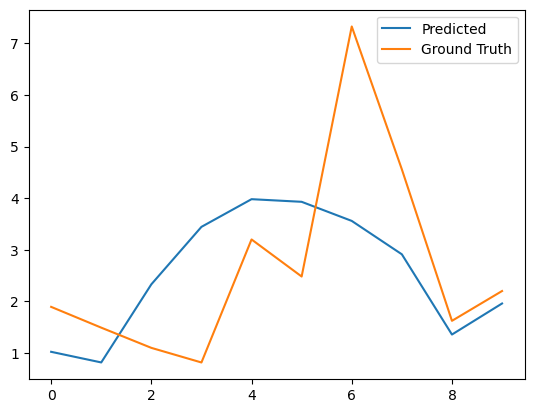

In [44]:
i = 6
phi = 0
plt.plot(preds[i, 0, :, phi], label='Predicted')
plt.plot(YValidation[i, :, phi], label='Ground Truth')
plt.legend()
plt.show()

In [ ]:
import torch
import numpy as np




def standerize2d(data, mean, std):
    mean = data.mean(dim=0)
    std = data.std(dim=0)
    return (data - mean) / std

def unstanderize2d(data, mean, std):
    return data * std + mean

data = torch.rand(100, 10,10) *5 +2
mean = data.mean(dim=0)
std = data.std(dim=0)
std_data = standerize2d(data, mean, std)
unstd_data = unstanderize2d(std_data, data.mean(dim=0), data.std(dim=0))
